In [1]:
!pip install tensorflow
!pip install keras

import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization, Activation, GlobalAveragePooling2D
from tensorflow.keras import regularizers
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

data_dir = "/content/drive/MyDrive/Teeth_Dataset"
train_dir = os.path.join(data_dir, "/content/drive/MyDrive/Teeth_Dataset/Training")
val_dir = os.path.join(data_dir, "/content/drive/MyDrive/Teeth_Dataset/Validation")
test_dir = os.path.join(data_dir, "/content/drive/MyDrive/Teeth_Dataset/Testing")

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical')

val_generator = val_test_datagen.flow_from_directory(
    val_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical')

test_generator = val_test_datagen.flow_from_directory(
    test_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False)

Found 3087 images belonging to 7 classes.
Found 1028 images belonging to 7 classes.
Found 1028 images belonging to 7 classes.


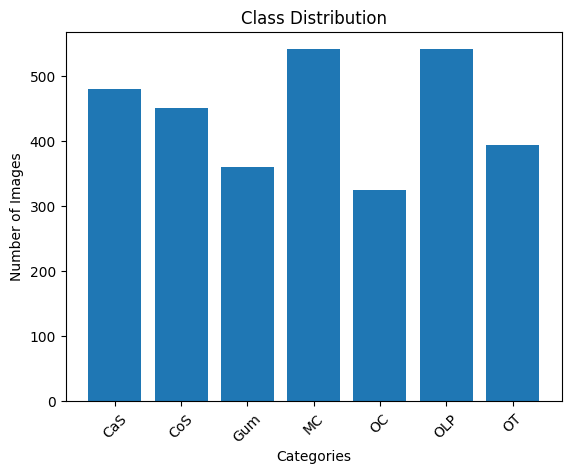

In [2]:
class_labels = list(train_generator.class_indices.keys())
class_counts = [len(os.listdir(os.path.join(train_dir, label))) for label in class_labels]
plt.bar(class_labels, class_counts)
plt.title("Class Distribution")
plt.xlabel("Categories")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.show()


In [4]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = True
for layer in base_model.layers[:-10]:
    layer.trainable = False   # unfreeze last 10 layers



model = Sequential([
    base_model,  # Add Pretrained Base Model
    GlobalAveragePooling2D(),
    Dense(128),
    BatchNormalization(),
    Activation('relu'),
    Dense(64),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.2),
    Dense(7, activation='softmax')
])

model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 7)                   │             455 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,431,431 (9.28 MB)

 Trainable params: 905,543 (3.45 MB)

 Non-trainable params: 1,525,888 (5.82 MB)

In [5]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [6]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'teeth_classification.weights.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True
)

In [7]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True
)

In [8]:
reduce_lr_on_plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6
)

In [9]:
history = model.fit(train_generator, validation_data=val_generator, epochs=50 ,  callbacks=[checkpoint, early_stopping, reduce_lr_on_plateau])


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 1168s 12s/step - accuracy: 0.3301 - loss: 1.8155 - val_accuracy: 0.3298 - val_loss: 2.0429 - learning_rate: 1.0000e-04
Epoch 2/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 51s 529ms/step - accuracy: 0.6100 - loss: 1.1150 - val_accuracy: 0.3054 - val_loss: 2.5704 - learning_rate: 1.0000e-04
Epoch 3/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 50s 511ms/step - accuracy: 0.7095 - loss: 0.8840 - val_accuracy: 0.3444 - val_loss: 2.4152 - learning_rate: 1.0000e-04
Epoch 4/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 49s 507ms/step - accuracy: 0.7490 - loss: 0.7650 - val_accuracy: 0.3687 - val_loss: 2.3198 - learning_rate: 1.0000e-04
Epoch 5/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 49s 507ms/step - accuracy: 0.8078 - loss: 0.6523 - val_accuracy: 0.4397 - val_loss: 1.8834 - learning_rate: 5.0000e-05
Epoch 6/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 82s 511ms/step - accuracy: 0.8406 - loss: 0.5690 - val_accuracy: 0.5730 - val_loss: 1.2863 - learning_rate: 5.0000e-05
Epoch 7/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 50s 520ms/step - acc

In [10]:
test_loss, test_acc = model.evaluate(test_generator)
print('Test accuracy:', test_acc)

33/33 ━━━━━━━━━━━━━━━━━━━━ 362s 11s/step - accuracy: 0.9993 - loss: 0.0126
Test accuracy: 0.9980545043945312


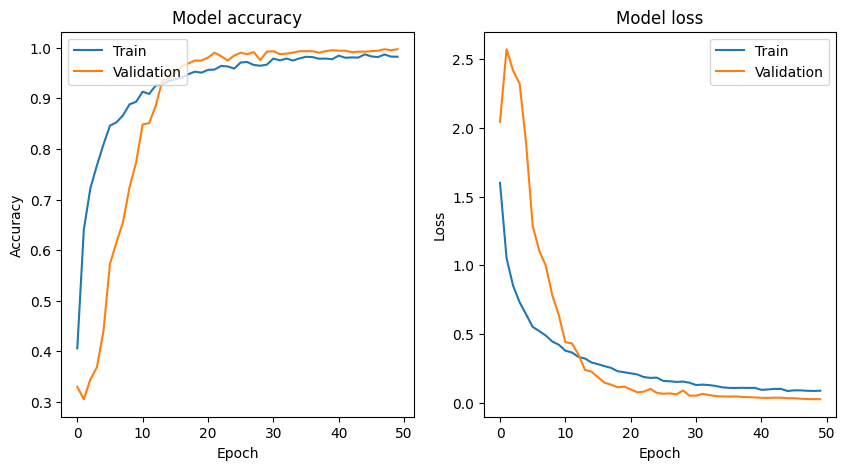

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')


plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])

In [12]:
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes

33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 226ms/step


In [13]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(true_classes, predicted_classes)

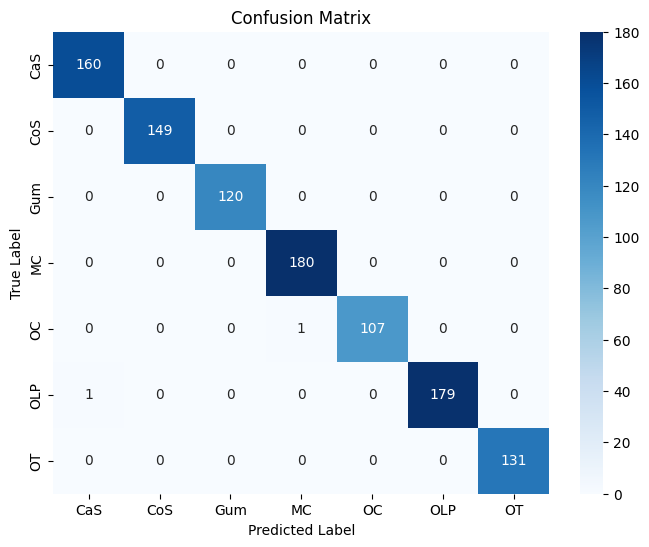

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [15]:
from sklearn.metrics import classification_report
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

              precision    recall  f1-score   support

         CaS       0.99      1.00      1.00       160
         CoS       1.00      1.00      1.00       149
         Gum       1.00      1.00      1.00       120
          MC       0.99      1.00      1.00       180
          OC       1.00      0.99      1.00       108
         OLP       1.00      0.99      1.00       180
          OT       1.00      1.00      1.00       131

    accuracy                           1.00      1028
   macro avg       1.00      1.00      1.00      1028
weighted avg       1.00      1.00      1.00      1028

